In [26]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [27]:
model_path = "./Models/unet_segmentation_pothole.keras"

## Image Segmentation

In [28]:
def predict_and_display_from_image_path(imgarr: np.ndarray, model_path):
    print(imgarr)
    def dice_coef(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)

    # Load and preprocess the image
    img = imgarr / 255  # Read the image in grayscale and normalize
    original_img = img.copy()            # Copy for display purposes
    img = cv2.resize(img, (128, 128))    # Ensure the image is resized to the input shape
    img = np.expand_dims(img, axis=-1)   # Add channel dimension
    img = np.expand_dims(img, axis=0)    # Add batch dimension

    loaded_model = load_model(model_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
   
    prediction = loaded_model.predict(img)

    return prediction

## HOG LBP

In [29]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
import pickle

def resize_image(image_array):
    if image_array is not None:
        image_array = cv2.resize(image_array, (645, 645), interpolation=cv2.INTER_AREA)
        return image_array
    else:
        print(f"Failed to read image")

def convert_image_to_grayscale(image_array):
    return cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

def extract_hog_features(image_array):
    features, _ = hog(
        image_array,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True
    )
    return features

def pad_lbp_features(test_lbp, max_length=10):
    if isinstance(test_lbp, (list, np.ndarray)):
        if len(test_lbp) < max_length:
            pad_width = max_length - len(test_lbp)
            padded_lbp = np.pad(test_lbp, (0, pad_width), 'constant')
            return padded_lbp
        else:
            return test_lbp
    else:
        raise ValueError("Input 'test_lbp' must be a list or numpy array.")

def extract_lbp_features(image_array, radius=1, n_points=8):
    lbp_image = local_binary_pattern(image_array, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-8)
    lbp_hist = pad_lbp_features(lbp_hist)
    return lbp_hist

def extract_features_from_image(image_array, radius=1, n_points=8):
    image_array = resize_image(image_array)
    grayscale_image = convert_image_to_grayscale(image_array)
    hog_features = extract_hog_features(grayscale_image)
    lbp_features = extract_lbp_features(grayscale_image, radius, n_points)
    return hog_features, lbp_features

def predict_class(image_array):
    hog_features, lbp_features = extract_features_from_image(image_array)
    model_paths = [
        "./Models/knn_hog.pkl",
        "./Models/knn_lbp.pkl",
        "./Models/rf_hog.pkl",
        "./Models/rf_lbp.pkl",
        "./Models/svm_hog.pkl",
        "./Models/svm_lbp.pkl",
    ]

    model_names = [
        "knn_hog",
        "knn_lbp",
        "rf_hog",
        "rf_lbp",
        "svm_hog",
        "svm_lbp"
    ]

    results = {}

    for model_name, model_path in zip(model_names, model_paths):
        with open(model_path, 'rb') as file:
            Model = pickle.load(file)
        predicted_class = Model.predict([hog_features]) if "hog" in model_name else Model.predict([lbp_features])
        results[model_name] = predicted_class[0]

    return results

## SIFT

In [30]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

In [31]:
def splitt(x):
    return x.split()

def resizeImage(image: np.ndarray, size: tuple) -> np.ndarray:
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

def extract_sift_features(image):
    sift = cv2.SIFT_create()
    key_points, descriptors = sift.detectAndCompute(image, None)
    return key_points, descriptors

def generateDescriptorMatrices(image) -> pd.DataFrame:
    pca = joblib.load('./Models/pca_77.joblib') 
    KMeansModel = pickle.load(open("./Models/kmeans_445.pickle", "rb"))
    tfidf_vect:TfidfVectorizer = pickle.load(open("./Models/tfidf_445.pickle", "rb"))
    
    SVMModel = joblib.load('./Models/SVM_TFIDF_445.joblib')
    descriptor_list = []
    class_list = []
    image_class = []

    # extract descriptors from image
    keypoints, descriptor = extract_sift_features(image)

    # skip image because pca cannot be done
    if(descriptor.shape[0]) < 77:
        return None

    # add image descriptors
    descriptor_list.append(descriptor)
    
    for i in descriptor_list:
        reduced_descriptors = pca.fit_transform(i)
        class_labels = KMeansModel.predict(reduced_descriptors)
        class_list.append(class_labels)
    
    init = np.zeros(445, dtype=int)
    for i in class_list:
        init[i] += 1

    tfidf_matrix = tfidf_vect.fit_transform([init])

    prediction = SVMModel.predict(tfidf_matrix)
    print(prediction)
    if(prediction == None):
        prediction = [1,0]
        prediction[0] = "Invalid Image"
    elif(prediction[0] == "Pothole"):
        prediction[0] = 1
    else:
        prediction[0] = 0
    return prediction

def SIFT_Predict(image):
    resized = resizeImage(image, (256, 256))
    return generateDescriptorMatrices(resized)

## Testing

In [32]:
imgarr_color = cv2.imread("../Dataset/Resized_Images_256/Plain/1.Longeststraight0.png", 1)
imgarr_gray = cv2.imread("../Dataset/Resized_Images_256/Plain/1.Longeststraight0.png", 0)

In [33]:
def predict_image_class(image_color: np.ndarray, image_gray: np.ndarray):
    segmentedImage = predict_and_display_from_image_path(image_gray, model_path)
    HOG_LBP = predict_class(image_color)
    SIFT = SIFT_Predict(image_gray)
    HOG_LBP["sift_tfidf_svm"] = SIFT[0]
    print(SIFT)
    return [HOG_LBP, segmentedImage]

In [34]:
predictions = predict_image_class(imgarr_color, imgarr_gray)
predictions[0]

[[143 142 143 ... 133 133 137]
 [139 138 139 ... 129 128 128]
 [140 138 140 ... 128 127 128]
 ...
 [124 126 110 ... 122 117 131]
 [118 127 116 ... 119 117 130]
 [123 121 120 ... 124 124 129]]
1/1 [==============================] - 0s 141ms/step
['Plain']
['0']


{'knn_hog': 0,
 'knn_lbp': 0,
 'rf_hog': 0,
 'rf_lbp': 0,
 'svm_hog': 0,
 'svm_lbp': 0,
 'sift_tfidf_svm': '0'}

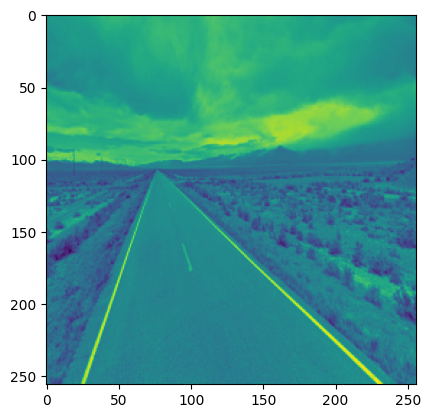

In [35]:
gray_arr = np.asarray(Image.fromarray(imgarr_color).convert("L"))
plt.imshow(gray_arr)